In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import giotto
import sklearn as skl
import plotly
import seaborn as sns
from giotto.time_series import Resampler

%load_ext autoreload
%autoreload 2

In [2]:
x = pd.read_csv('training_un7FCmp.csv')
y = pd.read_csv('target_ATndViR.csv')
xy = x.merge(y, on='ID')

In [3]:
npx = x.values
npy = y.values

In [4]:
intervals = npx[:,3:] - npx[:,2:-1]
df_intervals = pd.DataFrame(data=intervals, columns=pd.Index(['interval_%s' % n for n in range(49)])).stack().reset_index().rename(columns={'level_0':'id', 'level_1': 'time', 0:'x'})

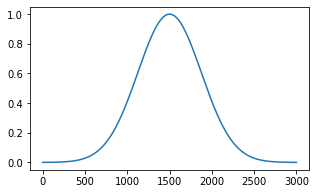

In [5]:
from scipy import signal
bigm = 3000 # Number of points in the output window
window = signal.gaussian(bigm, std=bigm/8)
plt.figure(figsize=(5, 3))
plt.plot(window)
plt.show()

In [6]:
# Rescaling to avoid perfect collapsing spike due to integer spacing
scale = 1000
print(f'Minimum spike interval: {df_intervals.x.min()}')

max_last_ts = int(xy.timestamp_49.max() * scale)
min_right_lim = max_last_ts + bigm
print(f'Max last spike timestamp: {max_last_ts}')
print(f'Minimum right limit: {min_right_lim}')

Minimum spike interval: 0.0011646282981550016
Max last spike timestamp: 43015
Minimum right limit: 46015


In [7]:
# Apply gaussian a spike + padding
f = lambda x: np.pad(window, (int(x), int(min_right_lim-x-bigm+1)), 'constant', constant_values=(0, 0))

In [8]:
# Sum all gaussian spikes
f2 = lambda x: np.sum(np.array(list(map(f, x * scale))), axis=0)

TARGET
0    691
1    150
Name: ID, dtype: int64
Plotting time-series...


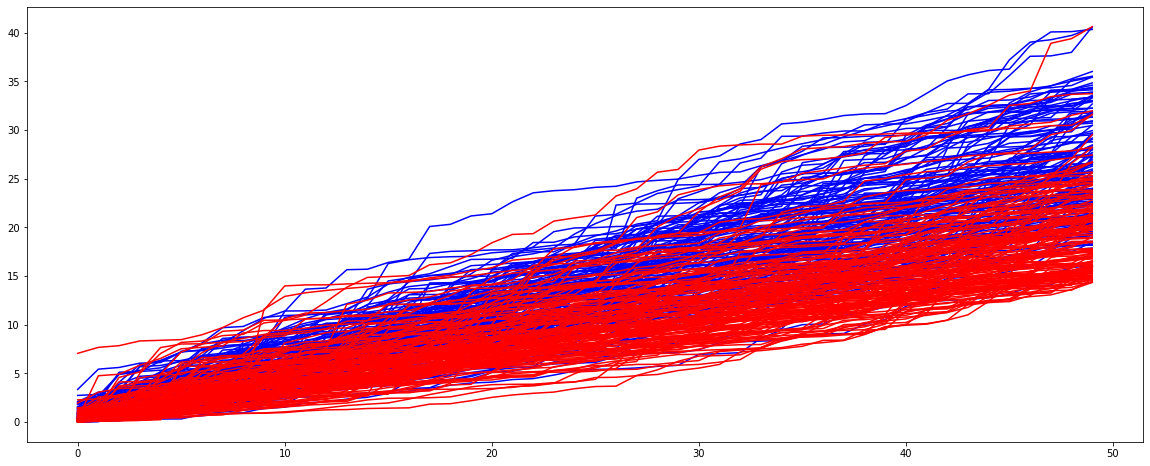

Creating gaussian spikes
Resampling...
Creating Takens Embedding...
Creating V-R Persistence Diagrams...


In [14]:
neuron_id = 7770
samples_per_label = 150
# filter by neuron_id
xy_nid = xy[xy.neuron_id == neuron_id]
xy_nid_cnt = xy_nid.groupby('TARGET').count().ID
print(xy_nid_cnt)

xy_balanced = xy_nid.groupby('TARGET').head(samples_per_label)
x_np = xy_balanced.values[:, 2:-1]
y_np = xy_balanced.values[:, -1:]

y_0 = y_np.ravel() == 0
y_1 = y_np.ravel() == 1

print('Plotting time-series...')
plt.figure(figsize=(20,8))
plt.plot(x_np[y_0].T, c='blue')
plt.plot(x_np[y_1].T, c='red')
plt.show()

print('Creating gaussian spikes')
x_gaus = np.array(list(map(f2, x_np)))

print('Resampling...')
period = 200
resamp = Resampler(period=period)
x_resamp = resamp.fit_transform(x_gaus.T).T

print('Creating Takens Embedding...')
from giotto.time_series import TakensEmbedding
te = TakensEmbedding(time_delay=1, dimension=3, parameters_type='fixed')
x_tak = np.apply_along_axis(te.fit_transform, 1, x_resamp)

print('Creating V-R Persistence Diagrams...')
from giotto.homology import VietorisRipsPersistence
vrp = VietorisRipsPersistence(max_edge_length=20, homology_dimensions=[0, 1, 2], n_jobs=-1)
x_vrpd = vrp.fit_transform(x_tak)

In [15]:
import numpy as np
import plotly.graph_objs as gobj
from giotto.diagrams._utils import _subdiagrams
def plot_betti_curves(betti_curves, homology_dimensions=None, samplings=None):
    """Plot the Betti curves of a single persistence diagram by homology
    dimension.
        
    Parameters
    ----------
    betti_curves : ndarray, shape (n_homology_dimension, n_values)
        Collection of ``n_homology_dimension`` discretised Betti curves.
        Entry i along axis 0 should be the Betti curve in homology dimension i.
    homology_dimensions : list of int or None, default: ``None``
        Homology dimensions for which the Betti curves should be plotted.
        If ``None``, all available dimensions will be used.
    samplings : ndarray, shape (n_homology_dimension, n_values), \
                default: ``None``
        For each homology dimension, (filtration parameter) values to be used
        on the x-axis against the corresponding values in `betti_curves` on
        the y-axis. If ``None``, the samplings will start at 0 with step 1.
    """
    if homology_dimensions is None:
        homology_dimensions = np.arange(0, betti_curves.shape[0])
    if samplings is None:
        samplings = np.arange(0, betti_curves.shape[1])
    layout = {
        "title": "Betti curves",
        "xaxis1": {
            "title": "Epsilon",
            "side": "bottom",
            "type": "linear",
            "ticks": "outside",
            "anchor": "x1",
            "showline": True,
            "zeroline": True,
            "showexponent": "all",
            "exponentformat": "e"
        },
        "yaxis1": {
            "title": "Betti number",
            "side": "left",
            "type": "linear",
            "ticks": "outside",
            "anchor": "y1",
            "showline": True,
            "zeroline": True,
            "showexponent": "all",
            "exponentformat": "e"
        },
        "plot_bgcolor": "white"
    }
    fig = gobj.Figure(layout=layout)
    fig.update_xaxes(zeroline=True, linewidth=1, linecolor='black',
                     mirror=False)
    fig.update_yaxes(zeroline=True, linewidth=1, linecolor='black',
                     mirror=False)

    for i, dimension in enumerate(homology_dimensions):
        fig.add_trace(gobj.Scatter(x=samplings,
                                   y=betti_curves[i, :],
                                   mode='lines', showlegend=False,
                                   hoverinfo='none'))
        
    fig.show()

In [37]:
from giotto.diagrams import BettiCurve
bc = BettiCurve()
a = bc.fit_transform(x_vrpd)
plot_betti_curves(a[0])

In [49]:
def compute_area_under_curve(a):
    features=[]
    for row in range(0,len(a)):
        a[row].sum(axis=1)
        features.append(a[row].sum(axis=1))
    return features


In [50]:
features=compute_area_under_curve(a)

In [53]:
features=pd.DataFrame(features)

In [70]:
pd.DataFrame(npx)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.0,53.0,0.166262,0.170520,0.176371,0.197565,0.212814,0.957631,1.177679,3.207268,...,14.700766,15.856531,15.906414,15.910547,16.079702,16.516175,16.988851,16.996101,17.019988,17.056403
1,1.0,7229.0,0.053270,0.133652,0.161603,0.530531,0.692537,0.730291,0.784066,1.023311,...,10.420048,11.577627,18.070029,18.825891,19.248378,19.539560,19.723312,19.978294,20.052356,20.123709
2,2.0,7770.0,0.600593,1.127467,1.289813,2.598660,3.826711,4.851020,5.025722,5.262254,...,24.635121,25.967167,26.270768,28.028523,29.584844,31.183257,31.218086,31.285777,33.160938,33.360947
3,3.0,7002.0,0.136037,0.655734,0.992514,1.490964,2.246825,2.855319,3.208054,3.325092,...,13.473805,13.688518,14.028203,14.178543,14.783635,15.151632,16.003356,16.282885,17.249543,17.259610
4,4.0,7678.0,0.200614,0.257171,0.288137,0.314078,0.486903,0.499591,0.534961,0.623986,...,11.298341,12.214740,13.072630,13.952573,14.013957,14.476091,14.724149,16.883795,17.052340,19.289922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16630,16630.0,5691.0,0.077914,0.708334,1.009554,1.125147,1.271336,1.299890,1.666290,1.718390,...,29.316422,30.307006,31.185741,31.227892,32.320902,32.701000,32.955075,33.016627,34.837705,34.874491
16631,16631.0,2341.0,0.485287,0.870193,0.959064,1.733133,1.755243,1.803468,1.841432,1.986925,...,17.151013,17.367892,17.727558,18.178916,18.521734,19.492522,19.515122,20.715555,21.217199,21.640693
16632,16632.0,8046.0,0.213619,0.290771,1.575419,1.650658,1.700773,1.856047,1.927563,1.950001,...,14.064862,14.092407,14.343008,14.428562,14.671081,14.791297,14.847738,14.916361,15.055357,15.192531
16633,16633.0,6855.0,2.669642,7.500198,8.710341,8.724346,8.760471,8.770804,8.786001,8.847625,...,15.555430,15.698512,15.782122,16.067267,16.499324,16.906955,17.444176,18.704728,22.082864,27.185064


In [85]:
X_without_topo=x_np
X_with_topo=np.concatenate([x_np,features],axis=1)

In [73]:
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [93]:

X_train, X_test, y_train, y_test = train_test_split( X_with_topo, y_np, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=4,
                              random_state=0)
clf.fit(X_train, y_train) 
cohen_kappa_score(clf.predict(X_test),y_test)

/Users/philippenguyen/code/topollini/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.4383259911894273

In [94]:

X_train, X_test, y_train, y_test = train_test_split( X_without_topo, y_np, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=4,
                              random_state=0)
clf.fit(X_train, y_train) 
cohen_kappa_score(clf.predict(X_test),y_test)

/Users/philippenguyen/code/topollini/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.4696132596685082